In [14]:
import pickle
import torch
import pandas as pd
import matplotlib.pyplot as plt
from exp2.data import load_stock_data, load_options_data, handle_scale_variant_feats, scale_features, Wrapper
from exp1.preprocessing import prepare_labels, build_features_short, isolate_option_types, build_dict, tag_returns_process_group
from joblib import Parallel, delayed

In [3]:
with open("../experiments/main_latest.pkl", "rb") as f:
    results = pickle.load(f)

In [11]:
results.keys()

dict_keys(['01', '02', '03', '04', '05', '06', '08', '09', '10'])

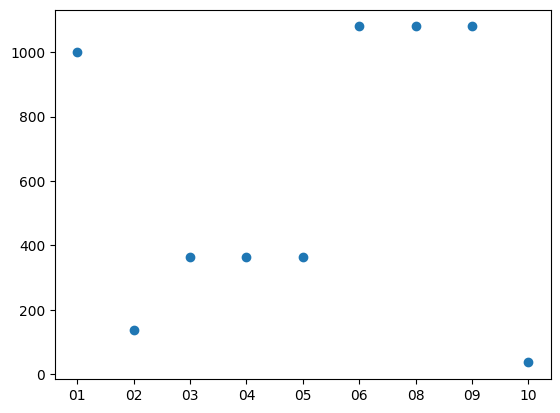

In [12]:
plt.scatter(
    list(results.keys()),
    [results[month]["final_capital"] for month in results.keys()],
)
None;

In [16]:
df_path = f"/Volumes/T7/backup/Documents/perso/repos_perso/options-modeling/data/lgbm-train/exp_round3/n16/df_01.csv"
train_df = pd.read_csv(df_path)
train_df.index = pd.to_datetime(train_df.index)

pt_path = f"/Volumes/T7/backup/Documents/perso/repos_perso/options-modeling/data/lgbm-train/exp_round3/n16/train_tensors_01.pt"
X_tensor, y_tensor, train_indices_tensor = torch.load(pt_path, weights_only=False)
X_tensor = Wrapper(X_tensor, train_indices_tensor, train_df)

In [20]:
indices_df = pd.DataFrame(X_tensor.indices, columns=["datetime", "strike", "expire_date"])
indices_df#.equals(indices_df.sort_values("datetime"))

,datetime,strike,expire_date
0,2023-01-03 13:15:00,-4.438742,2024-12-20
1,2023-01-03 13:30:00,-4.438742,2024-12-20
2,2023-01-03 13:45:00,-4.438742,2024-12-20
3,2023-01-03 14:00:00,-4.438742,2024-12-20
4,2023-01-03 14:15:00,-4.438742,2024-12-20
...,...,...,...
1349154,2023-01-23 15:15:00,2.38672,2024-12-20
1349155,2023-01-23 15:30:00,2.38672,2024-12-20
1349156,2023-01-23 15:45:00,2.38672,2024-12-20
1349157,2023-01-24 09:30:00,2.38672,2024-12-20


In [21]:
indices_df.sort_values("datetime")

,datetime,strike,expire_date
0,2023-01-03 13:15:00,-4.438742,2024-12-20
1175447,2023-01-03 13:15:00,1.032593,2024-12-20
341926,2023-01-03 13:15:00,-0.420945,2023-01-05
675319,2023-01-03 13:15:00,0.027014,2023-03-31
1021169,2023-01-03 13:15:00,0.506809,2023-12-29
...,...,...,...
625132,2023-01-24 10:00:00,-0.032429,2023-03-17
714357,2023-01-24 10:00:00,0.075854,2023-01-25
830564,2023-01-24 10:00:00,0.218739,2023-03-17
972158,2023-01-24 10:00:00,0.427958,2023-01-26


In [77]:
month = "07"
path = f"/Volumes/T7/backup/Documents/perso/repos_perso/options-modeling/data/lgbm-train/exp_round3/n16/df_{month}.csv"
window = 16

In [78]:
orig_df = pd.read_csv(path)

In [79]:
orig_df.dtypes

datetime                    object
strike                     float64
iv                         float64
expire_date                 object
bid                        float64
ask                        float64
delta                      float64
gamma                      float64
vega                       float64
theta                      float64
rho                        float64
open                       float64
close                      float64
low                        float64
high                       float64
underlying_volume          float64
label                      float64
percent_increase           float64
hours_to_max               float64
delta_volume               float64
time_to_expiry             float64
moneyness                  float64
intra_bar_return           float64
intra_bar_volatility       float64
relative_close_position    float64
up_down_gap                float64
dtype: object

In [5]:
orig_df.isna().sum()

datetime                       0
strike                         0
iv                             0
expire_date                    0
bid                            0
ask                            0
delta                          0
gamma                          0
vega                           0
theta                          0
rho                            0
open                       46788
close                      46788
low                        46788
high                       46788
underlying_volume          46788
label                          0
percent_increase               0
hours_to_max                   0
delta_volume                   0
time_to_expiry                 0
moneyness                  46788
intra_bar_return               0
intra_bar_volatility           0
relative_close_position    46788
up_down_gap                 3899
dtype: int64

In [8]:
stock_price_data = load_stock_data()
option_chain_data = load_options_data(month=month)

In [ ]:
stock_price_data.isna().sum()

date      0
open      0
low       0
high      0
close     0
volume    0
dtype: int64

In [ ]:
df_labeled = prepare_labels(stock_price_data, option_chain_data)

In [11]:
df_labeled.isna().sum()

strike                   0
iv                       0
expire_date              0
bid                      0
ask                      0
delta                    0
gamma                    0
vega                     0
theta                    0
rho                      0
open                 46788
close                46788
low                  46788
high                 46788
underlying_volume    46788
label                    0
percent_increase         0
hours_to_max             0
delta_volume             0
dtype: int64

inspect step by step to identify flaw

In [20]:
raw_keys = option_chain_data[0]
options_hist_data = [
    item
    for raw_values in option_chain_data[1:]
    for item in isolate_option_types(build_dict(raw_keys, raw_values))
]
options_chain_data_hist = pd.DataFrame(options_hist_data)

In [21]:
options_chain_data_hist.isna().sum()

quote_readtime         0
quote_time_hours       0
underlying_last        0
expire_date            0
dte                    0
delta                  0
gamma                  0
vega                   0
theta                  0
rho                    0
iv                     0
volume                 0
last                   0
size                   0
bid                    0
ask                    0
strike                 0
strike_distance        0
strike_distance_pct    0
type                   0
dtype: int64

In [24]:
# options data manip
options_chain_data_hist_reduced = options_chain_data_hist.rename(columns={"quote_readtime": "datetime"})
call_chain_data_hist_reduced = options_chain_data_hist_reduced.loc[
    options_chain_data_hist_reduced["type"] == "call",
    ["datetime", "strike", "iv", "expire_date", "bid", "ask", "volume", "delta", "gamma", "vega", "theta", "rho"]
]
put_chain_data_hist_reduced = options_chain_data_hist_reduced.loc[
    options_chain_data_hist_reduced["type"] == "put",
    ["datetime", "strike", "iv", "expire_date", "bid", "ask", "volume", "delta", "gamma", "vega", "theta", "rho"]
]

# stocks data manip
stock_price_data_15min = stock_price_data.loc[stock_price_data["date"].apply(
    lambda x:(":30" in x[:-3]) or (":15" in x[:-3]) or (":00" in x[:-3]) or (":45" in x[:-3])
), ["date", "open", "close", "low", "high", "volume"]]
stock_price_data_15min = stock_price_data_15min.rename(columns={"date": "datetime", "volume": "underlying_volume"})
stock_price_data_15min["datetime"] = stock_price_data_15min["datetime"].apply(lambda x: x[:-3])

In [25]:
stock_price_data_15min.isna().sum()

datetime             0
open                 0
close                0
low                  0
high                 0
underlying_volume    0
dtype: int64

In [26]:
# reset indexes
call_chain_data_hist_reduced = call_chain_data_hist_reduced.set_index("datetime")
put_chain_data_hist_reduced = put_chain_data_hist_reduced.set_index("datetime")
stock_price_data_15min = stock_price_data_15min.set_index("datetime")
concat_call_options_chain_prices = call_chain_data_hist_reduced.join(stock_price_data_15min, how="left")
concat_put_options_chain_prices = put_chain_data_hist_reduced.join(stock_price_data_15min, how="left")
concat_call_options_chain_prices = concat_call_options_chain_prices[concat_call_options_chain_prices.index.map(lambda x: " 16:00" not in x)]
df = concat_call_options_chain_prices.copy()
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [43]:
concat_call_options_chain_prices.isna().sum()

strike                   0
iv                       0
expire_date              0
bid                      0
ask                      0
volume                   0
delta                    0
gamma                    0
vega                     0
theta                    0
rho                      0
open                 46788
close                46788
low                  46788
high                 46788
underlying_volume    46788
dtype: int64

In [44]:
concat_call_options_chain_prices.loc[pd.isna(concat_call_options_chain_prices["open"])]

,strike,iv,expire_date,bid,ask,volume,delta,gamma,vega,theta,rho,open,close,low,high,underlying_volume
datetime,,,,,,,,,,,,,,,,
2023-07-03 13:00,350.0,1.97291,2023-07-03,93.89,94.01,11.0,0.99491,0.00038,0.00317,-0.12007,0.00809,NaN,NaN,NaN,NaN,NaN
2023-07-03 13:00,360.0,1.75790,2023-07-03,83.89,84.01,1.0,0.99423,0.00045,0.00339,-0.12031,0.00844,NaN,NaN,NaN,NaN,NaN
2023-07-03 13:00,370.0,1.54774,2023-07-03,73.88,74.02,0.0,0.99297,0.00057,0.00443,-0.11991,0.00893,NaN,NaN,NaN,NaN,NaN
2023-07-03 13:00,372.0,1.49328,2023-07-03,71.38,72.51,0.0,0.99322,0.00058,0.00378,-0.11484,0.00825,NaN,NaN,NaN,NaN,NaN
2023-07-03 13:00,373.0,1.43178,2023-07-03,70.35,71.51,0.0,0.99471,0.00052,0.00342,-0.10031,0.00879,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 15:45,640.0,0.12512,2025-12-19,1.68,4.60,0.0,0.08454,0.00179,1.07203,-0.00982,0.85291,NaN,NaN,NaN,NaN,NaN
2023-07-03 15:45,645.0,0.12621,2025-12-19,0.50,5.50,0.0,0.08001,0.00172,1.03647,-0.00979,0.81490,NaN,NaN,NaN,NaN,NaN
2023-07-03 15:45,650.0,0.12916,2025-12-19,2.76,3.40,0.0,0.08038,0.00167,1.03837,-0.00985,0.81498,NaN,NaN,NaN,NaN,NaN


In [41]:
df.isna().sum()

strike                   0
iv                       0
expire_date              0
bid                      0
ask                      0
volume                   0
delta                    0
gamma                    0
vega                     0
theta                    0
rho                      0
open                 46788
close                46788
low                  46788
high                 46788
underlying_volume    46788
dtype: int64

In [31]:
call_chain_data_hist_reduced.isna().sum(), \
stock_price_data_15min.isna().sum()

(strike         0
 iv             0
 expire_date    0
 bid            0
 ask            0
 volume         0
 delta          0
 gamma          0
 vega           0
 theta          0
 rho            0
 dtype: int64,
 open                 0
 close                0
 low                  0
 high                 0
 underlying_volume    0
 dtype: int64)

In [69]:
call_chain_data_hist_reduced.head()

,strike,iv,expire_date,bid,ask,volume,delta,gamma,vega,theta,rho
datetime,,,,,,,,,,,
2023-07-03 09:30,350.0,2.30995,2023-07-03,92.44,94.11,0.0,0.97765,0.00098,0.01239,-0.51492,0.00895
2023-07-03 09:30,360.0,1.67848,2023-07-03,82.48,83.36,0.0,0.99233,0.00058,0.00481,-0.16049,0.00989
2023-07-03 09:30,370.0,1.46017,2023-07-03,72.55,73.27,0.0,0.99124,0.00071,0.00531,-0.15029,0.00983
2023-07-03 09:30,372.0,1.55092,2023-07-03,70.55,71.45,0.0,0.98593,0.00104,0.00842,-0.23974,0.00994
2023-07-03 09:30,373.0,1.32625,2023-07-03,69.53,70.22,0.0,0.99395,0.00054,0.00448,-0.11521,0.00974


In [50]:
stock_price_data_15min.tail()

,open,close,low,high,underlying_volume
datetime,,,,,
2023-12-27 10:30,475.74,475.5500,475.54,475.790,385572
2023-12-27 10:15,475.40,475.4800,475.33,475.660,1003221
2023-12-27 10:00,476.01,476.0140,475.91,476.140,602754
2023-12-27 09:45,475.97,475.9350,475.81,476.035,478939
2023-12-27 09:30,475.44,475.8296,475.27,475.920,1055776


In [67]:
stock_price_data_15min.sort_index().loc[pd.to_datetime(stock_price_data_15min.index).month == 7]

,open,close,low,high,underlying_volume
datetime,,,,,
2023-07-03 09:30,442.92,443.1600,442.630,443.1800,1976699
2023-07-03 09:45,443.41,443.3500,443.135,443.5500,1538373
2023-07-03 10:00,443.50,443.4650,443.290,443.6800,842474
2023-07-03 10:15,443.44,443.3100,443.250,443.5200,910264
2023-07-03 10:30,443.49,443.4699,443.250,443.5700,1029310
...,...,...,...,...,...
2023-08-01 14:45,456.69,456.8350,456.620,456.8800,265176
2023-08-01 15:00,456.72,456.8000,456.700,456.8400,308808
2023-08-01 15:15,456.82,456.7500,456.740,456.9100,320173


In [74]:
list(stock_price_data_15min.sort_index().iloc[3230:3240].index)

['2023-07-03 11:00',
 '2023-07-03 11:15',
 '2023-07-03 11:30',
 '2023-07-03 11:45',
 '2023-07-03 12:00',
 '2023-07-03 12:15',
 '2023-07-03 12:30',
 '2023-07-03 12:45',
 '2023-07-05 09:30',
 '2023-07-05 09:45']

In [73]:
call_chain_data_hist_reduced.head().index[0] == stock_price_data_15min.sort_index().index[3224]

True

In [42]:
call_chain_data_hist_reduced.index.dtype, stock_price_data_15min.index.dtype

(dtype('O'), dtype('O'))

In [70]:
common_timestamps = call_chain_data_hist_reduced.index.intersection(stock_price_data_15min.index)
print(len(common_timestamps), "matching timestamps")

508 matching timestamps


In [ ]:
# Group the DataFrame
grouped = df.groupby(['strike', 'expire_date'])

# Process in parallel
results = Parallel(n_jobs=-1, backend='loky')(
    delayed(tag_returns_process_group)(strike, expire_date, group)
    for (strike, expire_date), group in grouped
)

# Combine results
df_labeled = pd.concat(results).sort_index()

# compute timestep delta from cumulative delta
df_labeled['date'] = df_labeled.index.date
df_labeled['delta_volume'] = (
    df_labeled.groupby(['date', 'strike', 'expire_date'])['volume']
    .diff()
    .fillna(0)
)

# drop rows with an index (datetime) with less than 1 week to max index datetime and with a label of 0
df_labeled = clean_tail_edge_cases(df_labeled)
df_labeled = df_labeled.drop(columns=['date', 'volume'])

In [14]:
df_labeled.loc[pd.isna(df_labeled["open"])].head(10)

/Users/simon/Documents/venvs/options_env/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,strike,iv,expire_date,bid,ask,delta,gamma,vega,theta,rho,open,close,low,high,underlying_volume,label,percent_increase,hours_to_max,delta_volume
datetime,,,,,,,,,,,,,,,,,,,
2023-07-03 13:00:00,443.0,0.16739,2024-06-28,38.08,39.20,0.62707,0.00501,1.64430,-0.06367,2.37664,NaN,NaN,NaN,NaN,NaN,0.099976,0.0,0.0,0.0
2023-07-03 13:00:00,429.0,0.17317,2024-03-15,40.17,41.04,0.68957,0.00537,1.29606,-0.07266,1.86756,NaN,NaN,NaN,NaN,NaN,0.099976,0.0,0.0,0.0
2023-07-03 13:00:00,470.0,0.10242,2023-09-29,2.11,2.17,0.18052,0.01175,0.57705,-0.04154,0.19023,NaN,NaN,NaN,NaN,NaN,0.099976,0.0,0.0,0.0
2023-07-03 13:00:00,410.0,0.19512,2024-03-28,55.80,56.66,0.76142,0.00406,1.15381,-0.07092,2.08204,NaN,NaN,NaN,NaN,NaN,0.099976,0.0,0.0,0.0
2023-07-03 13:00:00,432.0,0.15714,2023-11-17,27.52,27.94,0.68941,0.00818,0.95742,-0.08711,1.05051,NaN,NaN,NaN,NaN,NaN,0.099976,0.0,0.0,0.0
2023-07-03 13:00:00,310.0,0.66027,2023-07-21,134.51,135.12,0.99353,0.00023,0.01857,-0.07447,0.15780,NaN,NaN,NaN,NaN,NaN,0.099976,0.0,0.0,0.0
2023-07-03 13:00:00,390.0,0.60077,2023-07-06,54.06,54.36,0.98370,0.00145,0.01857,-0.16708,0.04008,NaN,NaN,NaN,NaN,NaN,0.099976,0.0,0.0,0.0
2023-07-03 13:00:00,430.0,0.19580,2025-03-21,61.50,66.50,0.66969,0.00306,1.99888,-0.05072,4.01315,NaN,NaN,NaN,NaN,NaN,0.099976,0.0,0.0,0.0
2023-07-03 13:00:00,432.0,0.15885,2023-12-15,30.00,30.54,0.68450,0.00741,1.05486,-0.08229,1.24435,NaN,NaN,NaN,NaN,NaN,0.099976,0.0,0.0,0.0


In [ ]:
df_labeled = build_features_short(df_labeled, window=window)

In [ ]:
df_labeled.isna().sum()

In [ ]:
df_labeled = handle_scale_variant_feats(df_labeled)

In [ ]:
df_labeled.isna().sum()

In [ ]:
df_labeled = scale_features(df_labeled)